In [46]:
#!pip install pyvis

In [47]:
from pyvis.network import Network

In [32]:
from configparser import ConfigParser
from tqdm import tqdm
import datetime
import networkx as nx
import matplotlib.pyplot as plt
import requests
import openai
import json
import os

In [3]:
# Get API key stored in local cfg file
# How to is available here : https://towardsdatascience.com/keeping-credentials-safe-in-jupyter-notebooks-fbd215a8e311

parser = ConfigParser()
_ = parser.read('ObsidianGPT.cfg')
openai.api_key = parser.get('my_api', 'auth_key')

In [4]:
def generate_text(prompt, GPTmodel):
    response = openai.ChatCompletion.create(model=GPTmodel,messages=[{"role": "user", "content": prompt}])
    return response.choices[0].message.content.strip()

In [5]:
def create_obsidian_vault(vault_name, parent_directory):
    '''Creates or Updates and Obsidian vault, in a given directory. Params are vault_name, parent_directory'''
    vault_path = os.path.join(parent_directory, vault_name)
    
    # Create the vault directory
    os.makedirs(vault_path, exist_ok=True)

    # Create default folders within the vault
    os.makedirs(os.path.join(vault_path, "attachments"), exist_ok=True)
    os.makedirs(os.path.join(vault_path, "notes"), exist_ok=True)
    
    return vault_path

# Connect to GPT4

In [6]:
# Get the list of models for different kinds of data from the GPT API
models_prompt = """
Please list the key components of the field of psychology in the following structured format:

1. Subfields: List the most relevant subfields of psychology.
2. Key Figures: List the most relevant key figures in psychology and the subfields they are associated with.
3. Theories: List the most relevant theories in psychology and the key figures associated with them.
4. Concepts: List the most relevant concepts in psychology and the theories they are associated with.

"""

In [7]:
%%time
# Get the list of models, for each data type and problem type
models_text = generate_text(models_prompt, GPTmodel="gpt-4") #or gpt-3.5-turbo for faster results vs lower query quality
models_text

CPU times: user 57.8 ms, sys: 25.8 ms, total: 83.6 ms
Wall time: 1min 29s


'1. Subfields:\n   a. Cognitive Psychology\n   b. Developmental Psychology\n   c. Social Psychology\n   d. Clinical Psychology\n   e. Biological Psychology\n   f. Industrial-Organizational Psychology\n   g. Health Psychology\n   h. Forensic Psychology\n   i. Personality Psychology\n\n2. Key Figures:\n   a. Sigmund Freud - Psychoanalysis\n   b. Carl Jung - Analytical Psychology\n   c. B.F. Skinner - Behaviorism\n   d. Jean Piaget - Developmental Psychology\n   e. Albert Bandura - Social Learning Theory\n   f. Lev Vygotsky - Cognitive Development\n   g. Carl Rogers - Humanistic Psychology\n   h. Abraham Maslow - Humanistic Psychology, Hierarchy of Needs\n   i. Stanley Milgram - Social Psychology\n   j. Philip Zimbardo - Social Psychology\n\n3. Theories:\n   a. Psychoanalysis - Sigmund Freud\n   b. Behaviorism - B.F. Skinner\n   c. Cognitive Development Theory - Jean Piaget\n   d. Social Learning Theory - Albert Bandura\n   e. Zone of Proximal Development - Lev Vygotsky\n   f. Humanistic 

In [9]:
today=datetime.datetime.now()

In [11]:
#save models dict to disk with current date
with open(f'raw_models_{today}.txt', 'w') as convert_file:
     convert_file.write(json.dumps(models_text))

In [38]:
response_=models_text
lines = response_.strip().split('\n')
lines

['1. Subfields:',
 '   a. Cognitive Psychology',
 '   b. Developmental Psychology',
 '   c. Social Psychology',
 '   d. Clinical Psychology',
 '   e. Biological Psychology',
 '   f. Industrial-Organizational Psychology',
 '   g. Health Psychology',
 '   h. Forensic Psychology',
 '   i. Personality Psychology',
 '',
 '2. Key Figures:',
 '   a. Sigmund Freud - Psychoanalysis',
 '   b. Carl Jung - Analytical Psychology',
 '   c. B.F. Skinner - Behaviorism',
 '   d. Jean Piaget - Developmental Psychology',
 '   e. Albert Bandura - Social Learning Theory',
 '   f. Lev Vygotsky - Cognitive Development',
 '   g. Carl Rogers - Humanistic Psychology',
 '   h. Abraham Maslow - Humanistic Psychology, Hierarchy of Needs',
 '   i. Stanley Milgram - Social Psychology',
 '   j. Philip Zimbardo - Social Psychology',
 '',
 '3. Theories:',
 '   a. Psychoanalysis - Sigmund Freud',
 '   b. Behaviorism - B.F. Skinner',
 '   c. Cognitive Development Theory - Jean Piaget',
 '   d. Social Learning Theory - Al

# Psychology Exploration 

## v1 - Static Graph

In [48]:
category = ''
for line in lines:
    print(line)
    line = line.strip()
    if not line:  # if it's an empty line, skip
        continue
    if line.endswith(':'):  # if it's a category line
        category = line[:-1]
        continue
    item = line[line.index('. ')+2:]  # get rid of "a. ", "b. ", etc.
    if '-' in item:  # if there's a '-' in the line, it's a figure or theory
        item, associated = item.split('-', 1)
        item = item.strip()
        associated = associated.strip()
        G.add_edge(item, associated)
    elif 'related to' in item:  # if there's a 'related to' in the line, it's a concept
        item, related = item.split('related to', 1)
        item = item.strip()
        related = related.strip().strip('()')  # remove parentheses
        G.add_edge(item, related)
    else:  # if it's a subfield, just add the node
        G.add_node(item, type=category.lower())

1. Subfields:
   a. Cognitive Psychology
   b. Developmental Psychology
   c. Social Psychology
   d. Clinical Psychology
   e. Biological Psychology
   f. Industrial-Organizational Psychology
   g. Health Psychology
   h. Forensic Psychology
   i. Personality Psychology

2. Key Figures:
   a. Sigmund Freud - Psychoanalysis
   b. Carl Jung - Analytical Psychology
   c. B.F. Skinner - Behaviorism
   d. Jean Piaget - Developmental Psychology
   e. Albert Bandura - Social Learning Theory
   f. Lev Vygotsky - Cognitive Development
   g. Carl Rogers - Humanistic Psychology
   h. Abraham Maslow - Humanistic Psychology, Hierarchy of Needs
   i. Stanley Milgram - Social Psychology
   j. Philip Zimbardo - Social Psychology

3. Theories:
   a. Psychoanalysis - Sigmund Freud
   b. Behaviorism - B.F. Skinner
   c. Cognitive Development Theory - Jean Piaget
   d. Social Learning Theory - Albert Bandura
   e. Zone of Proximal Development - Lev Vygotsky
   f. Humanistic Psychology - Carl Rogers, Abra

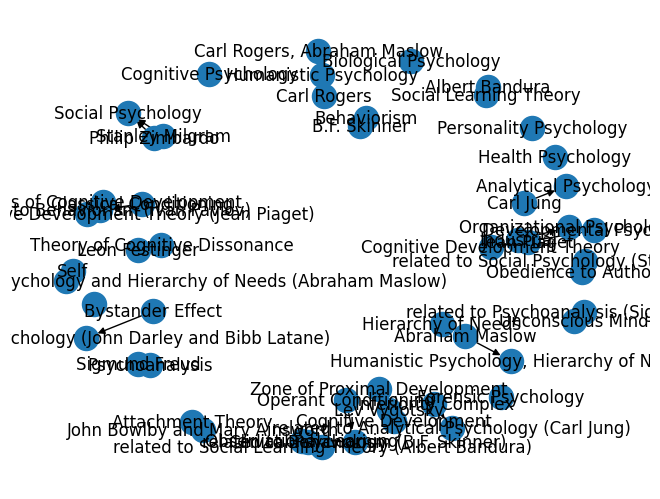

In [43]:
# Draw the graph
nx.draw(G, with_labels=True)
plt.show()

## v2 - Interactive Graph

In [51]:
category = ''
for line in lines:
    line = line.strip()
    if not line:  # if it's an empty line, skip
        continue
    if line.endswith(':'):  # if it's a category line
        category = line[:-1]
        continue
    item = line[line.index('. ')+2:]  # get rid of "a. ", "b. ", etc.
    print(item)
    if '-' in item:  # if there's a '-' in the line, it's a figure or theory
        item, associated = item.split('-', 1)
        item = item.strip()
        associated = associated.strip()
        G.add_edge(item, associated)
    elif 'related to' in item:  # if there's a 'related to' in the line, it's a concept
        item, related = item.split('related to', 1)
        item = item.strip()
        related = related.strip().strip('()')  # remove parentheses
        G.add_edge(item, related)
    else:  # if it's a subfield, just add the node
        G.add_node(item, type=category.lower())

# Convert to a pyvis network
net = Network(notebook=True)
net.from_nx(G)

# Show the interactive graph
net.show("psychology_graph.html")

Cognitive Psychology
Developmental Psychology
Social Psychology
Clinical Psychology
Biological Psychology
Industrial-Organizational Psychology
Health Psychology
Forensic Psychology
Personality Psychology
Sigmund Freud - Psychoanalysis
Carl Jung - Analytical Psychology
B.F. Skinner - Behaviorism
Jean Piaget - Developmental Psychology
Albert Bandura - Social Learning Theory
Lev Vygotsky - Cognitive Development
Carl Rogers - Humanistic Psychology
Abraham Maslow - Humanistic Psychology, Hierarchy of Needs
Stanley Milgram - Social Psychology
Philip Zimbardo - Social Psychology
Psychoanalysis - Sigmund Freud
Behaviorism - B.F. Skinner
Cognitive Development Theory - Jean Piaget
Social Learning Theory - Albert Bandura
Zone of Proximal Development - Lev Vygotsky
Humanistic Psychology - Carl Rogers, Abraham Maslow
Hierarchy of Needs - Abraham Maslow
Theory of Cognitive Dissonance - Leon Festinger
Attachment Theory - John Bowlby and Mary Ainsworth
Classical Conditioning - related to Behaviorism (